installing packages

In [1]:
!pip install transformers datasets pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


###import lib

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import LEDTokenizer, LEDForConditionalGeneration

##load csv

In [4]:
file_path = './wikiHow.csv'
df = pd.read_csv(file_path)



# Display first few rows of the dataset

In [5]:
df.head()

,Article Title,Subheading,Paragraph
0,How to Rent a Post Office Box: 12 Steps (with ...,Fill out the application forms.,"You can apply online at usps.com, or print out..."
1,How to Rent a Post Office Box: 12 Steps (with ...,Prepare two forms of ID.,"Whether you apply online or in-person, you'll ..."
2,How to Rent a Post Office Box: 12 Steps (with ...,Pay your fees in advance.,"You can reserve it for 3, 6 or 12 months.Note ..."
3,How to Rent a Post Office Box: 12 Steps (with ...,Collect your post office box keys.,You should receive two keys for every box. Exp...
4,How to Rent a Post Office Box: 12 Steps (with ...,Aim to collect your mail in a timely manner.,Given that there's limited space in your post ...


## Data Preprocessing

In [6]:
# Remove NA values and duplicates
df = df.dropna()
df = df.drop_duplicates()


after removing dup

In [7]:
print(df.shape)

(12871, 3)


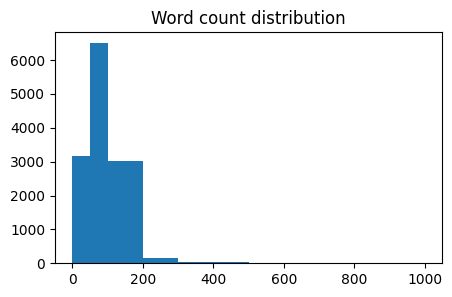

In [8]:
# Add a new column 'length' to the dataframe, which counts the number of words in each paragraph
df['length'] = df['Paragraph'].map(lambda x: len(x.split(" ")))

# Assign the word count column to a variable
numOfWords = df['length']

# Import the required library for plotting
from matplotlib import pyplot as plt

# Create the plot with a specified figure size
fig = plt.figure(figsize=(5, 3))

# Plot a histogram of the word count distribution, specifying the bin ranges
plt.hist(numOfWords.to_numpy(), bins=[0, 50, 100, 200, 300, 500, 1000])

# Add a title to the plot
plt.title("Word count distribution")

# Show the plot
plt.show()


nearly **200** outliers were removed

In [9]:
tempdf = df[df.length <= 200]
print(tempdf.shape)

(12686, 4)


# Fine-tuning with LED:

In [10]:
#import model version
tokenizer = LEDTokenizer.from_pretrained("allenai/led-base-16384")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Define key parameters
max_input_length = 1024   # Maximum token length for input (paragraphs)
max_output_length = 64    # Maximum token length for output (headings)
batch_size = 16           # Batch size for training

# Function to process data into model inputs
def process_data_to_model_inputs(batch):
    # Tokenize the inputs (paragraphs) and labels (headings)
    inputs = tokenizer(
        batch["Paragraph"],                 # Text of the paragraph
        padding="max_length",               # Pad to max_length
        truncation=True,                    # Truncate if text exceeds max_length
        max_length=max_input_length,        # Set the max input length to 1024
    )

    outputs = tokenizer(
        batch["Subheading"],                   # Text of the heading
        padding="max_length",               # Pad to max_length
        truncation=True,                    # Truncate if heading exceeds max_length
        max_length=max_output_length,       # Set the max output length to 64
    )

    # Assign the tokenized input ids and attention mask to the batch
    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # Create global attention mask lists, all set to 0 initially
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # Set the global attention on the first token in the batch to 1
    batch["global_attention_mask"][0][0] = 1

    # Assign the tokenized outputs to the batch
    batch["labels"] = outputs.input_ids

    # Ensure that the PAD token is ignored during the loss computation
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch


**Data** **Spliting**

In [12]:
import numpy as np
train, validate, test = np.split(tempdf.sample(frac=1, random_state=42), [int(.6*len(df)), int(.7*len(df))])
print(train.shape)
print(validate.shape)
print(test.shape)
validate = validate[:20]
print(validate.shape)

(7722, 4)
(1287, 4)
(3677, 4)
(20, 4)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
print(train)
print(validate)

                                           Article Title  \
10460  How to Grow Saffron: 13 Steps (with Pictures) ...   
11919  Simple Ways to Carve Turkey Breast: 10 Steps (...   
10985  How to Support an Autistic Person (with Pictur...   
7789                5 Ways to Use a Smartphone - wikiHow   
2112             3 Ways to Make Cold Porcelain - wikiHow   
...                                                  ...   
11155  How to Adhere Concrete to Concrete (with Pictu...   
1646   How to Write a Statement of Purpose: 15 Steps ...   
7056   How to Start a Support Group (with Pictures) -...   
12347  How to Fix Stick Drift on PS4: 5 Fast & Easy Ways   
9318   How to Install an Over The Range Microwave: 13...   

                                              Subheading  \
10460              Prepare the soil with organic matter.   
11919           Pull out the wishbone with your fingers.   
10985  Schedule downtime after stressful or taxing ev...   
7789        Understand what kind of sma

In [16]:
from datasets import Dataset
train_dataset = Dataset.from_pandas(train)
val_dataset = Dataset.from_pandas(validate)

train_dataset = train_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["Article Title", "Subheading", "Paragraph", "length", "__index_level_0__"],
)

val_dataset = val_dataset.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["Article Title", "Subheading", "Paragraph", "length", "__index_level_0__"],
)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)

val_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "global_attention_mask", "labels"],
)


Map:   0%|          | 0/7722 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

We’ll be using **rouge** metric for measuring
performance.


In [17]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2fa5f3eea3353f72799c14a6460080172cc41a13a66369bf9333bbb079f85bd3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [18]:
from datasets import load_metric
from transformers import AutoModelForSeq2SeqLM
led = AutoModelForSeq2SeqLM.from_pretrained("allenai/led-base-16384", gradient_checkpointing=True, use_cache=False)

led.config.num_beams = 2
led.config.max_length = 64
led.config.min_length = 2
led.config.length_penalty = 2.0
led.config.early_stopping = True
led.config.no_repeat_ngram_size = 3

rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid
    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import transformers
transformers.logging.set_verbosity_info()

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    output_dir="./",
    logging_steps=5,
    eval_steps=10,
    save_steps=10,
    save_total_limit=2,
    gradient_accumulation_steps=4,
    num_train_epochs=10
)

pytorch_model.bin:   0%|          | 0.00/648M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

<ipython-input-18-636c663916cb>:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")


The repository for rouge contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/rouge.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [19]:
trainer = Seq2SeqTrainer(
    model=led,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

***** Running training *****
  Num examples = 7,722
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 4
  Total optimization steps = 1,200
  Number of trainable parameters = 161,844,480
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,2.152900,1.785071,0.191700,0.181700,0.182400
20,2.129500,1.727933,0.191200,0.215300,0.199500
30,2.170000,1.719635,0.247100,0.263100,0.250000
40,2.153800,1.725903,0.212100,0.253000,0.217400
50,2.152200,1.740086,0.221900,0.249500,0.220900
60,2.043200,1.752729,0.286600,0.269000,0.270400
70,2.043300,1.717124,0.225600,0.226500,0.218900
80,2.151100,1.700823,0.252700,0.235800,0.237200



***** Running Evaluation *****
  Num examples = 20
  Batch size = 16
Generate config GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 64,
  "min_length": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 2,
  "pad_token_id": 1,
  "use_cache": false
}

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Saving model checkpoint to ./checkpoint-10
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transf

KeyboardInterrupt: 

stopping with step 80 becuz we got a high precision on step 60 , we gonna use that

In [32]:
import pandas as pd
from datasets import Dataset, load_metric, load_dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration
import torch

sample_paragraph = "Virat kohli is an inspiration to many people around the world"
data = [sample_paragraph]
df = pd.DataFrame(data, columns=['Paragraph'])
df["Paragraph"][0]
df_test = Dataset.from_pandas(df)
df_test

Dataset({
    features: ['Paragraph'],
    num_rows: 1
})

In [33]:
tokenizer = LEDTokenizer.from_pretrained("/content/checkpoint-60")
model = LEDForConditionalGeneration.from_pretrained("/content/checkpoint-60").to("cuda").half()

def generate_answer(batch):
  inputs_dict = tokenizer(batch["Paragraph"], padding="max_length", max_length=512, return_tensors="pt", truncation=True)
  input_ids = inputs_dict.input_ids.to("cuda")
  attention_mask = inputs_dict.attention_mask.to("cuda")
  global_attention_mask = torch.zeros_like(attention_mask)

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch["generated_heading"] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

result = df_test.map(generate_answer, batched=True, batch_size=2)

loading file vocab.json
loading file merges.txt
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
loading file tokenizer.json
loading configuration file /content/checkpoint-60/config.json
Model config LEDConfig {
  "_name_or_path": "allenai/led-base-16384",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "LEDForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "attention_window": [
    1024,
    1024,
    1024,
    1024,
    1024,
    1024
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 768,
  "decoder_attention_heads": 12,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 12,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 2,
  "id2label": {
    "0": "LABEL_0",
   

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [34]:
result["generated_heading"]

['Virat kohli']